# ML: Unsupervised algorithm - DBSCAN - Customer Segmentation

## Introduction

__Please note__: for this example we will use the following dataset which can be downloaded from the Kaggle website https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

The dataset corresponds to data from a supermarket, which, through loyalty cards, has data on its customers, such as customer ID, age, gender, annual income and spending score, which is something it assigns to the customer based on its defined parameters such as customer behaviour and purchase data.

The purpose is to make a customer segmentation, trying to understand the customers and separate them into different groups according to their preferences, and once the division is made, provide the marketing team with the profile of each group so that they can plan the strategy in each segment.

## 1. Import of libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## 2. Load datasets

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
58,59,Female,27,46,51
64,65,Male,63,48,51
18,19,Male,52,23,29
138,139,Male,19,74,10
114,115,Female,18,65,48
92,93,Male,48,60,49
42,43,Male,48,39,36
128,129,Male,59,71,11
168,169,Female,36,87,27
137,138,Male,32,73,73


## 3. Dataset analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Let's eliminate the variable that identifies each client as we are not going to use it for modelling and describe the magnitude of the variables:

In [4]:
df=df.drop(columns='CustomerID')

In [5]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


The variables are in the same order of magnitude and we could not scale them but we will do it later to get used to it.

Next step is to perform different visualisations of the dataset to learn as much as possible about our data. In this case we are going to analyse the differences between men and women in relation to the rest of the variables.

In [6]:
df.groupby('Gender').agg({"Age":["count","mean"],
                         'Annual Income (k$)':'mean',
                         'Spending Score (1-100)':'mean'})

Age            Annual Income (k$) Spending Score (1-100)
       count       mean               mean                   mean
Gender                                                           
Female   112  38.098214          59.250000              51.526786
Male      88  39.806818          62.227273              48.511364

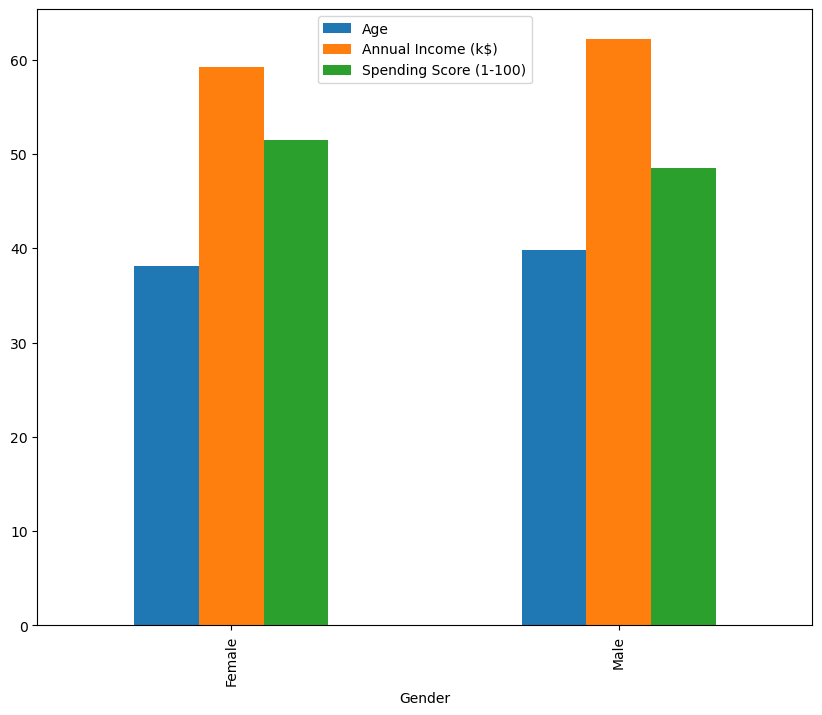

In [7]:
df.groupby('Gender').mean().plot(kind='bar',figsize=(10,8))

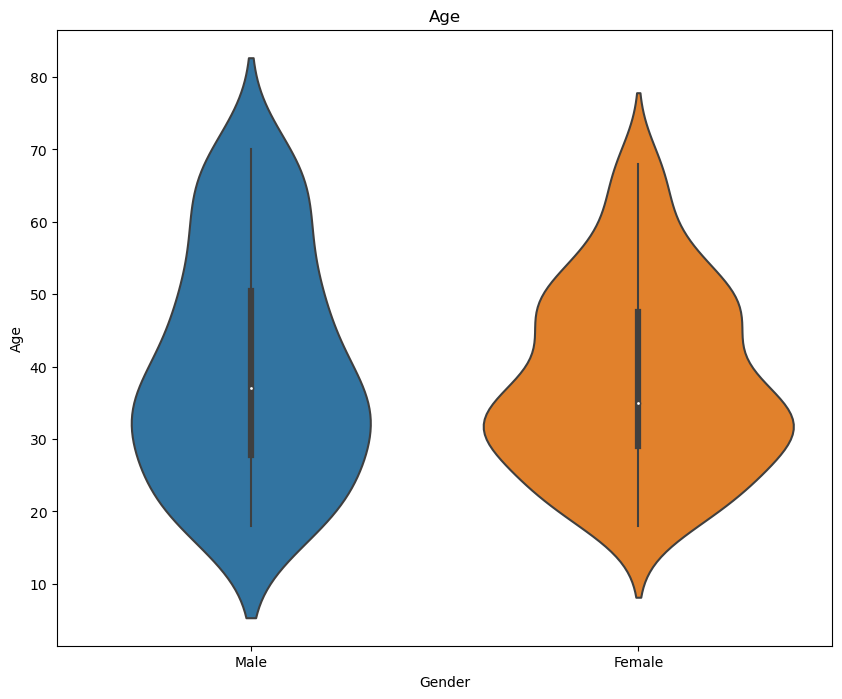

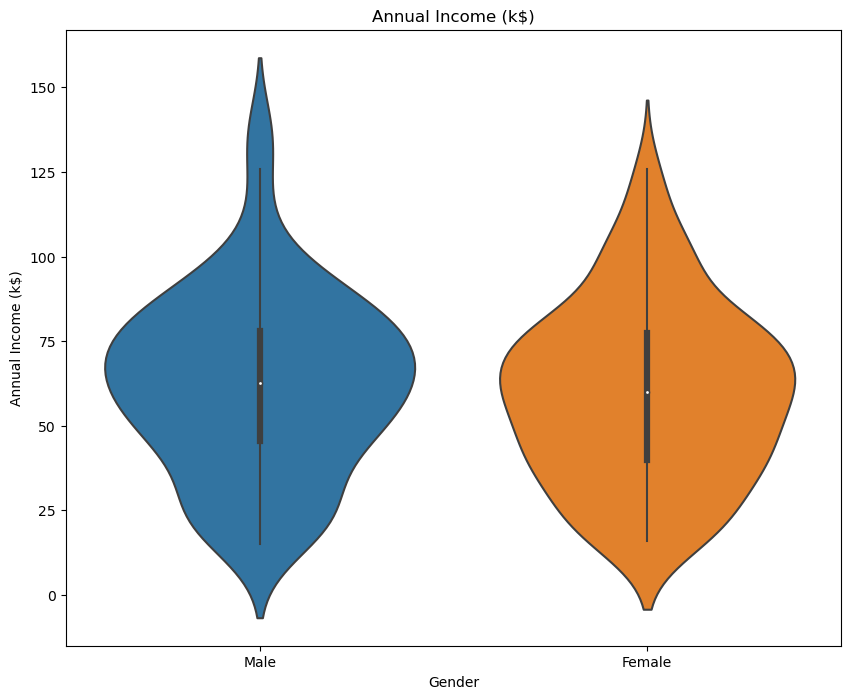

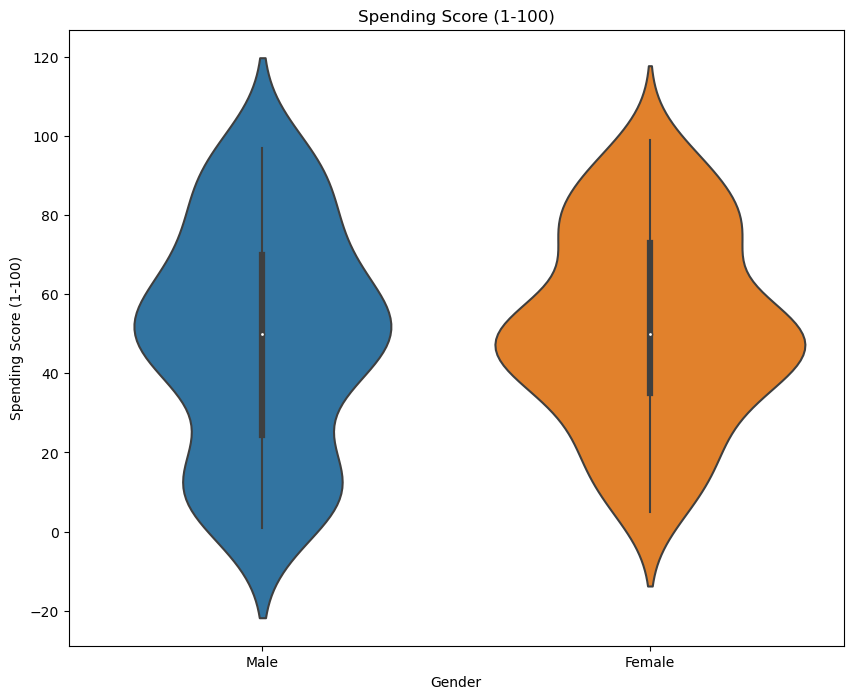

In [8]:
names = df.columns
for i in range(1,4):
    plt.figure(figsize=(10,8))
    sns.violinplot(x=df.Gender,y=df.iloc[:,i])
    plt.title(names[i])
    plt.show()

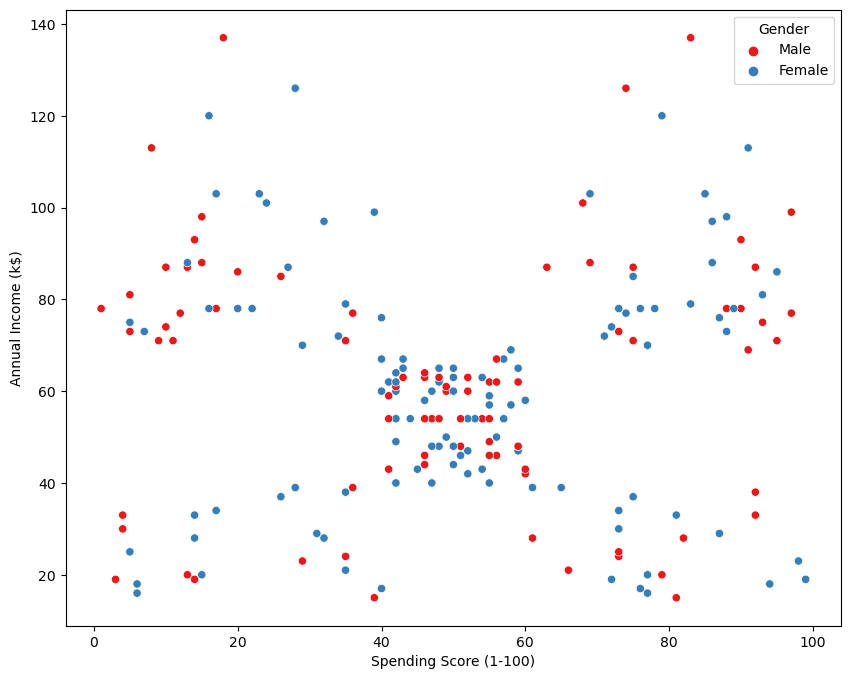

In [9]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=df['Spending Score (1-100)'],
                y=df['Annual Income (k$)'],
                hue=df['Gender'],
                palette= 'Set1');

It doesn't seem to have outliers and the relationship between income and score does not have a clear linear relationship. We calculate the correlation to confirm this with the corr function:

In [10]:
df.corr()

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


## 4. Models training

Start the modelling phase by selecting the numerical variables of the dataset and scaling them with the sklearn StandardScaler. Check the result with the describe function.

In [11]:
df_num = df.select_dtypes(include = 'number').copy()
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Age                     200 non-null    int64
 1   Annual Income (k$)      200 non-null    int64
 2   Spending Score (1-100)  200 non-null    int64
dtypes: int64(3)
memory usage: 4.8 KB


In [12]:
df_num_scl = StandardScaler().fit_transform(df_num)
pd.DataFrame(df_num_scl).describe()

,0,1,2
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-9.603429e-17,-6.128431e-16,-1.121325e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


Two parameters for DBSCAN:

* Use for the min_samples the recommended minimum as the dataset has a small number of observations (min_samples=3).
* For the epsilon value calculate the distances for this value of 3. 

For this use the knn algorithm (K neighbours) with k=3, we will plot the distance and the value that doubles the curve will be the chosen density value.

0.2851517131304658


Text(0, 0.5, 'Distance')

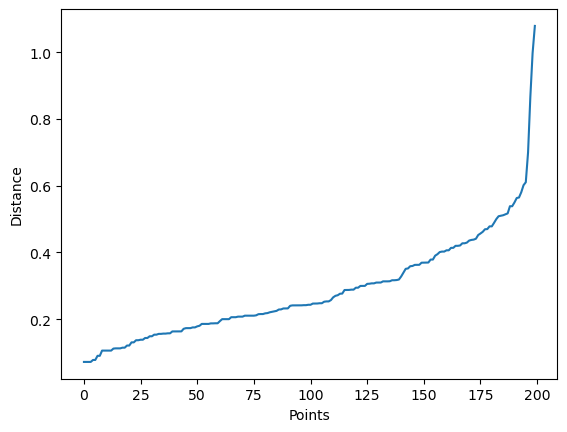

In [13]:
from sklearn.neighbors import NearestNeighbors

k=3

d=pd.DataFrame(df_num_scl)
d_knn = d

# Calculamos KNN
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(d_knn)
distances, indices = neighbors.kneighbors(d_knn)
distances = np.sort(distances, axis=0)

# Distancias
distances = distances[:,1]
print(distances.mean())
i = np.arange(len(distances))

sns.lineplot(
    x = i, 
    y = distances
)

plt.xlabel("Points")
plt.ylabel("Distance")


See that the optimal epsilon value is around 0.6. Therefore we will use min_samples=3 and eps=0.6.

In [14]:
dbscan = DBSCAN(eps=0.6, min_samples=3).fit(df_num_scl)
labels = dbscan.labels_
df['dbscan']=labels
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),dbscan
0,Male,19,15,39,-1
1,Male,21,15,81,0
2,Female,20,16,6,-1
3,Female,23,16,77,0
4,Female,31,17,40,0


Train the model with these parameters and add the model output to the dataset in order to identify where each observation has been classified and to visualise them.

See that the model creates three clusters and leaves 14 observations (with value -1) unclassified that the company's expert has to study separately, confirming the data first.
Perform different visualisations to analyse the results.

number of noise(s):  14


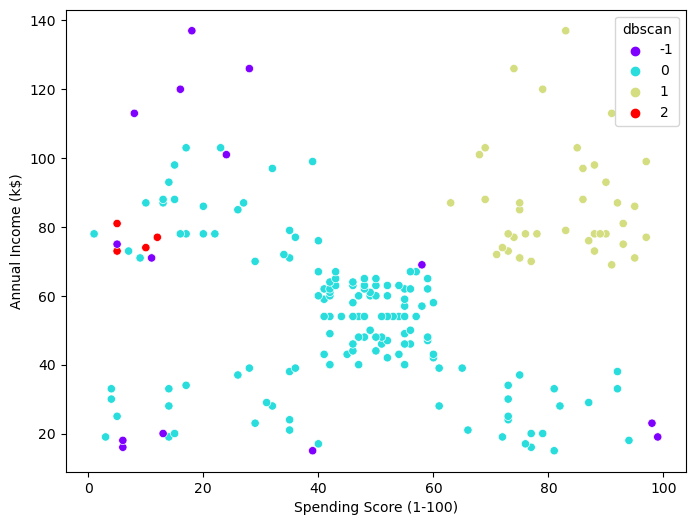

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['Spending Score (1-100)'],
                y=df['Annual Income (k$)'],
                hue=df['dbscan'],
                palette= 'rainbow')

n_noise_ = list(labels).count(-1)
print('number of noise(s): ', n_noise_)

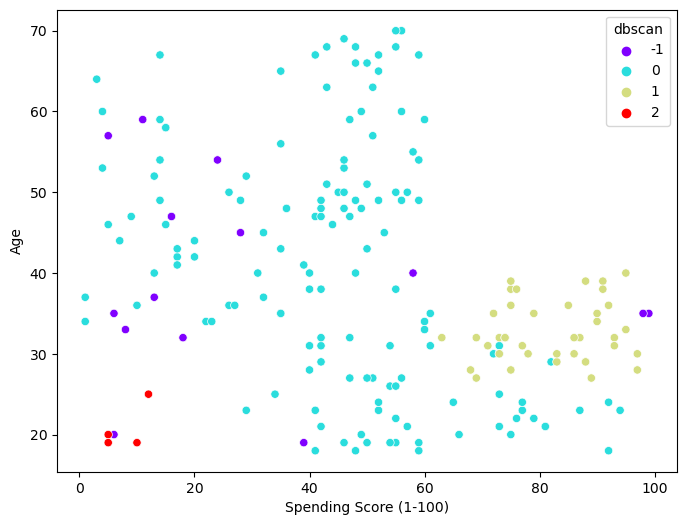

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['Spending Score (1-100)'],
                y=df['Age'],
                hue=df['dbscan'],
                palette= 'rainbow');
#Resultado del código ejecutado:

Once we have created the clusters and visualised how they are grouped, see how the individuals in each cluster are profiled on average. Use the variable Gender to see how it is distributed within each cluster:

In [17]:
df.groupby(['dbscan','Gender']).agg({"Age":["count","mean"],
                         'Annual Income (k$)':'mean',
                         'Spending Score (1-100)':'mean'})
#Resultado del código ejecutado:

Age            Annual Income (k$) Spending Score (1-100)
              count       mean               mean                   mean
dbscan Gender                                                           
-1     Female     9  40.888889          63.000000              37.777778
       Male       5  36.000000          71.200000              17.800000
 0     Female    82  39.304878          51.975610              45.317073
       Male      61  43.295082          53.229508              43.606557
 1     Female    21  32.190476          86.047619              81.666667
       Male      18  33.277778          87.111111              82.666667
 2     Male       4  20.750000          76.250000               8.000000